# Florida Panthers - Feature Selection
* StellarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* October 8, 2021

## Hypothesis
Two very important components of a machine learning model are feature selection and feature engineering. Our idea is that adding some more features to the StellarAlgo retention model could improve performance of the model.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *
from ngboost import NGBClassifier

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password ··················


In [15]:
lkupclientid = 93 # panthers

cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrNHLPanthers].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

CNXN.commit()
cursor.close()

df.shape

(15660, 55)

### In order to compare two sets of features, we need to create some datasets for training and evalution:

In [16]:
# choose the features for the stellar base retention model
features = [
    "dimCustomerMasterId",
    "attendancePercent",
    "distToVenue",
    "isNextYear_Buyer",
    "missed_games_1",
    "missed_games_2",
    "missed_games_over_2",
    "productGrouping",
    "recency",
    "renewedBeforeDays",
    "source_tenure",
    "totalSpent",
    "year"
]

# select 90% of the data for training
df_train = df.sample(frac=0.9, random_state=786).reset_index(drop=True)

# create the eval datasets for A and B
df_eval = df.drop(df_train.index).reset_index(drop=True)

# choose features for each train dataset
df_train = df_train[features]

# choose features for each train dataset
df_eval = df_eval[features]

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (14094, 13)
Unseen Data For Predictions: (1566, 13)



In [17]:
df_train.head()

,dimCustomerMasterId,attendancePercent,distToVenue,isNextYear_Buyer,missed_games_1,missed_games_2,missed_games_over_2,productGrouping,recency,renewedBeforeDays,source_tenure,totalSpent,year
0,688534,0.916667,None,0,4,0,0,Full Season,0,68,4745,1036.0,2019
1,158979,1.000000,None,1,2,0,0,Full Season,0,69,3285,5272.0,2019
2,433921,1.000000,None,0,0,0,0,Half Season,0,212,2190,2604.0,2021
3,202879,0.491667,None,1,0,0,1,Full Season,0,49,8030,64001.2,2017
4,150189,0.647059,None,0,6,3,0,Full Season,0,185,1825,2040.0,2017


## Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [ ]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.80,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
        "attendancePercent",
        "distToVenue",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2",
        "recency",
        "renewedBeforeDays",
        "source_tenure",
        "totalSpent"
    ]
);

### Let's add one extra model not included in the default pycaret algorithms (ngboost), then we can execute each model and see the performance metrics:

In [23]:
# adding an extra classifier ngboost
ngc = NGBClassifier()
ngboost = create_model(ngc)

model_matrix = compare_models(
    fold=10,
    include=["ada","dt","gbc","et","knn","lightgbm","lr","rf",ngboost,"xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
5,Light Gradient Boosting Machine,0.7771,0.8493,0.8221,0.7620,0.7909,0.5530,0.5550,0.0310
7,Random Forest Classifier,0.7659,0.8383,0.8055,0.7544,0.7791,0.5306,0.5320,0.2210
9,Extreme Gradient Boosting,0.7653,0.8434,0.7991,0.7569,0.7773,0.5297,0.5307,0.4390
2,Gradient Boosting Classifier,0.7584,0.8328,0.8080,0.7432,0.7741,0.5154,0.5177,0.1250
3,Extra Trees Classifier,0.7478,0.8162,0.7874,0.7383,0.7619,0.4945,0.4959,0.2050
8,NGBClassifier,0.7256,0.8024,0.7905,0.7081,0.7469,0.4492,0.4527,1.9140
0,Ada Boost Classifier,0.7228,0.7968,0.7791,0.7092,0.7423,0.4439,0.4464,0.1950
1,Decision Tree Classifier,0.6943,0.6943,0.6960,0.7041,0.7000,0.3884,0.3885,0.0160
4,K Neighbors Classifier,0.6157,0.6530,0.6389,0.6217,0.6301,0.2304,0.2306,0.0330
6,Logistic Regression,0.5787,0.6355,0.7939,0.5719,0.6601,0.1472,0.1582,0.0140


## Results

### The top model is performing well, so let's compare it against our unseen evaluation dataset:

In [24]:
best_model = create_model(model_matrix)

unseen_predictions = predict_model(best_model, data=df_eval)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7748,0.8451,0.8149,0.7621,0.7876,0.5486,0.5500
1,0.7677,0.8491,0.7941,0.7625,0.7780,0.5347,0.5352
2,0.7872,0.8568,0.8460,0.7641,0.8030,0.5730,0.5766
3,0.7704,0.8506,0.8391,0.7450,0.7893,0.5390,0.5436
4,0.7890,0.8532,0.8287,0.7751,0.8010,0.5770,0.5785
5,0.7879,0.8522,0.8391,0.7686,0.8023,0.5746,0.5771
6,0.7879,0.8560,0.8201,0.7783,0.7987,0.5750,0.5759
7,0.7675,0.8483,0.8097,0.7548,0.7813,0.5338,0.5353
8,0.7551,0.8245,0.8028,0.7412,0.7708,0.5088,0.5107
9,0.7835,0.8576,0.8270,0.7685,0.7967,0.5658,0.5676


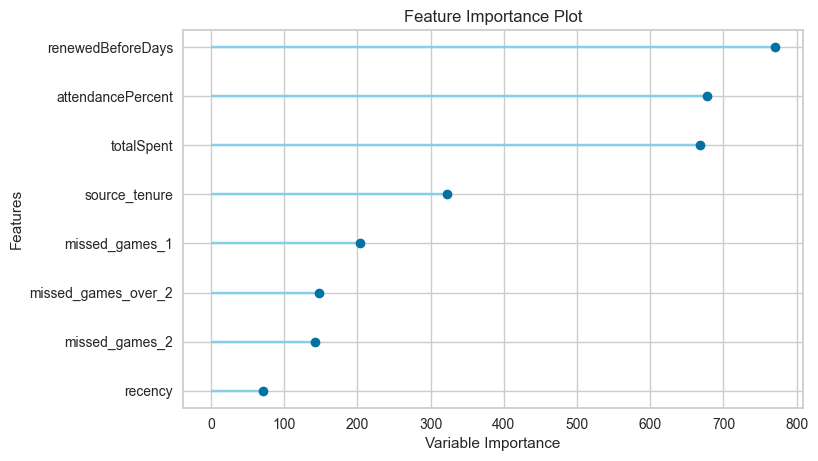

In [25]:
plot_model(best_model, plot='feature')

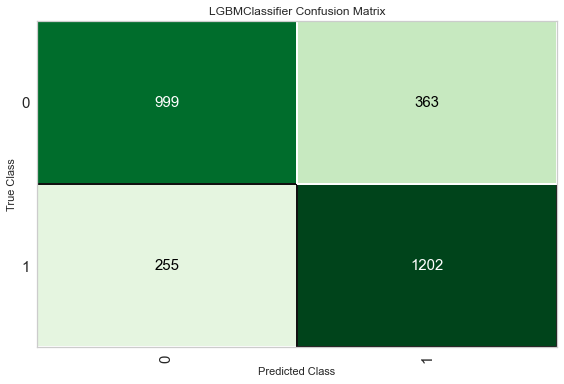

In [26]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above

## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?